# Get Data

In [35]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer 

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing") # datasets\\housing
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" # https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path) # create a directory in my workspace to where the file should be saved
    tgz_path = os.path.join(housing_path, "housing.tgz") # datasets\\housing\\housing.tgz - the file path
    urllib.request.urlretrieve(housing_url, tgz_path)  # download the file from housing_url to local tgz_path
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) # extract the csv
    housing_tgz.close()

**os.path.isdir**

Return True if path is an existing directory. 

**os.makedirs** 

Recursive directory creation function. Like mkdir(), but makes all intermediate-level directories needed to contain the leaf directory.

**gzip**

A file format and a software application used for file compression and decompression, the final compressed file usually has the extension .tar.gz or .tgz.

**urllib.request.urlretrieve(url[, filename[, reporthook[, data]]])**

Copy a network object denoted by a URL to a local file, if necessary. If the URL points to a local file, or a valid cached copy of the object exists, the object is not copied. Return a tuple (filename, headers) where filename is the local file name under which the object can be found, and headers is whatever the info() method of the object returned. The second argument, if present, specifies the file location to copy to (if absent, the location will be a tempfile with a generated name).

**tarfile.open(name=None, mode='r', fileobj=None, bufsize=10240, **kwargs)**

Return a TarFile object for the pathname *name*.

**TarFile.close()**

Close the TarFile. In write mode, two finishing zero blocks are appended to the archive.

**TarFile.extractall(path=".", members=None, *, numeric_owner=False)**

Extract all members from the archive to the current working directory or directory *path*. 

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing = load_housing_data()
# housing.head()

In [5]:
# housing.info()

In [6]:
# housing["ocean_proximity"].value_counts()

In [7]:
# housing.describe()

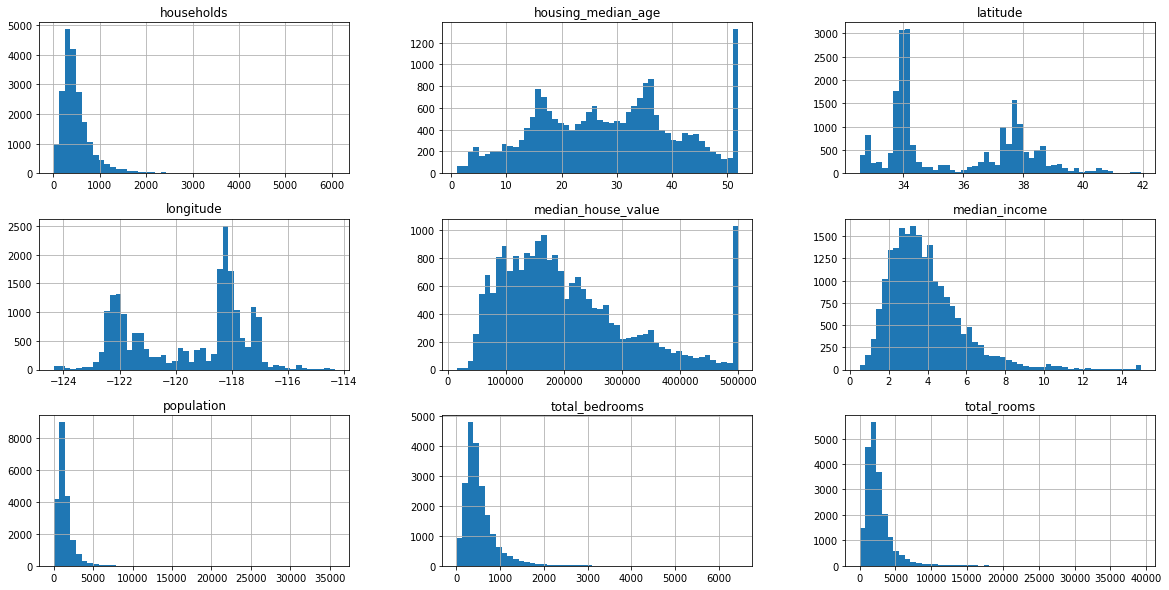

In [8]:
%matplotlib inline
housing.hist(bins=50, figsize=(20,10))
plt.show()

`%matplotlib inline`

Matplotlib relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command %matplotlib inline. This  tells Jupyter to set up Matplotlib so it uses Jupyter's own back end.

**matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)**

*bins* decides number of bars

*figsize=(float, float)* width, height in inches. If not provided, defaults to rcParams["figure.figsize"] = [6.4, 4.8] = [6.4, 4.8].

## Create a Test Set
A common solution to create a **consistent test set** is to use each instance’s **identifier** to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a **hash** of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256<sup>1</sup>). This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

Note:
1. a byte = 8 bits, 11111111 is the largest possible btye (=255).

In [9]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

`zlib.crc32(data[, value])` Computes a CRC (Cyclic Redundancy Check) checksum of data. The result is an unsigned 32-bit integer.

`np.int64(identifier)` convert identifier's data type to int64

`int64` integer -9223372036854775808 (-2 ** 63) to 9223372036854775807 (+2 ** 63)

`& 0xffffffff` mask is there only to ensure compatibility with Python 2 and 3. In Python 2 the same function could return a signed integer, in a range from -(2^31) to (2^31) - 1, masking this with the 0xffffffff mask normalises the value to a signed. (Source: [function test_set_check() explained](https://stackoverflow.com/questions/50646890/how-does-the-crc32-function-work-when-using-sampling-data))

[What is 0xffffffff or ffffffff?](https://answers.yahoo.com/question/index?qid=20110415123235AAolpb6)

[What is checksum?](https://www.howtogeek.com/363735/what-is-a-checksum-and-why-should-you-care/)

[crc32](https://kite.com/python/docs/zlib.crc32)

In [10]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column] # ids is a pandas Series storing all the identifiers of the data
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio)) # return a Series of boolean, flagging each id if it is within or out of the test set.
    return data.loc[~in_test_set], data.loc[in_test_set] #return a non-test df and a test df

A **lambda function** is a small anonymous function. A lambda function can take any number of arguments, but can only have one expression. The power of lambda is better shown when you use them as an anonymous function inside another function. (Source: [Python Lambda](https://www.w3schools.com/python/python_lambda.asp))

`id_` No semantics are associated with a trailing underscore. According to PEP 8, the style guide for Python, users are urged to use trailing underscores in order to not conflict with Python keywords and/or Python built-ins.

`DataFrame.loc` Access a group of rows and columns by label(s) or a boolean array.`df.loc[[False, False, True]]` select row no.3 only.



In [11]:
housing_with_id = housing.reset_index()
# housing_with_id.head()

In [12]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [13]:
# housing["median_income"].hist()

`numpy.Inf`

IEEE 754 floating point representation of (positive) infinity.

In [14]:
# housing["income category"] = pd.cut(housing["median_income"], bins=[0.0,1.5,3.0,4.5,6.0,np.inf], labels=[1,2,3,4,5])
# housing.head()

In [15]:
a = np.array([0,1,2,3,4,5])
pd.cut(a, bins =[1,2, np.inf], labels=['a','b'])

[NaN, NaN, a, b, b, b]
Categories (2, object): [a < b]

`pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise')`

Bin values into discrete intervals.

`bins`: int, sequence of scalars, or IntervalIndex. The criteria to bin by. 
- int : Defines the number of equal-width bins in the range of x. The range of x is extended by .1% on each side to include the minimum and maximum values of x.
- sequence of scalars : Defines the bin edges allowing for non-uniform width. No extension of the range of x is done.
- IntervalIndex : Defines the exact bins to be used. Note that IntervalIndex for bins must be non-overlapping.

In [16]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]< 5, 5.0, inplace=True)
# housing.head()

In [17]:
# a = pd.Series([0,1,2,3,4,5,8])
# b = np.ceil(a / 1.5)
# print(b)
# b.where(b <5, 5.0)

`numpy.ceil(x[, out])`

Return the ceiling of the input, element-wise. The ceil of the scalar x is the smallest integer i, such that i >= x. It is often denoted as [x].

`Series.where(self, cond, other=nan, inplace=False, axis=None, level=None, errors='raise', try_cast=False)`

Replace values where the condition is False.

other : Entries where cond is False are replaced with corresponding value from other. 

[inplace]('https://stackoverflow.com/questions/43893457/python-pandas-understanding-inplace-true') : Whether to perform the operation in place on the data.

In [18]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
sss

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

**Stratified sampling** the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

**StratifiedShuffleSplit** This cross-validation object is a merge of **StratifiedKFold** and **ShuffleSplit**, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

**K-fold Cross Validation(CV)** divides the data into folds and ensures that each fold is used as a testing set at some point.

<img src='https://miro.medium.com/max/1886/1*IjKy-Zc9zVOHFzMw2GXaQw.png'>

**Stratified k-fold cross validation** the process of rearranging the data so as to ensure that each fold is a good representative of the whole.

<img src='https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2015/11/skfold-768x530.png'>

**Shuffle Split** will randomly sample your entire dataset during each iteration to generate a training set and a test set. The test_size and train_size parameters control how large the test and training test set should be for each iteration. Since you are sampling from the entire dataset during each iteration, values selected during one iteration, could be selected again during another iteration.

In [19]:
for train_index, test_index in sss.split(housing,housing["income_cat"]):
    sss_train_set = housing.loc[train_index]
    sss_test_set = housing.loc[test_index]

`split(X, y)`

Generate indices to split data into training and test set.

train_index = array([17606, 18632, 14650, ..., 13908, 11159, 15775], dtype=int64)


In [20]:
# housing["income_cat"].hist()

In [21]:
# sss_train_set["income_cat"].hist()

In [22]:
# sss_test_set["income_cat"].hist()

In [23]:
def proportion_calculator(df,column):
    return df[column].value_counts()/len(df)

a = proportion_calculator(housing,"income_cat")
# a

In [24]:
train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [25]:
#convert a dictionary to dataframe
compare_prop = pd.DataFrame({
    "overall":proportion_calculator(housing,"income_cat"),
    "random_test":proportion_calculator(test_set,"income_cat"),
    "sss_test":proportion_calculator(sss_test_set,"income_cat"),
})

# compare_prop

In [26]:
compare_prop["Random error %"] = (compare_prop["random_test"]/compare_prop["overall"] - 1) *100
compare_prop["SSS error %"] = (compare_prop["sss_test"]/compare_prop["overall"] - 1) *100

compare_prop

,overall,random_test,sss_test,Random error %,SSS error %
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309


In [27]:
for set in (sss_train_set,sss_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)

# Discover and Visualize the Data

In [28]:
# make a cope of the TRAIN data
housing_train = sss_train_set.copy()

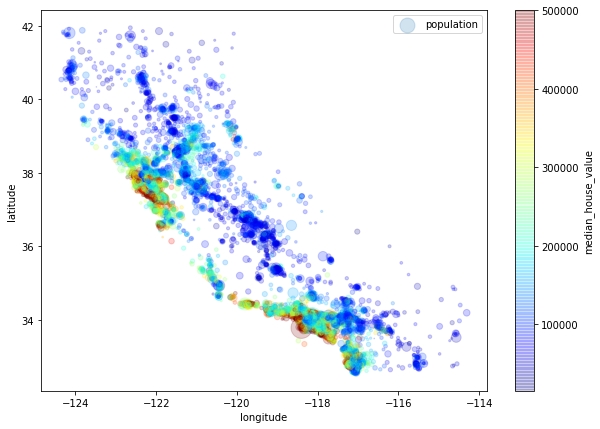

In [29]:
housing_train.plot(kind="scatter",
                   x="longitude",y="latitude",
                   figsize=(10,7),
                   alpha=0.2, # alpha sets the opacity of the scatter dots
                   s=housing["population"]/80, # s sets the radius of the dots
                   label="population",
                   c="median_house_value", cmap = plt.get_cmap("jet"), colorbar = True, # c sets the color
                   sharex = False
)
# The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

In [30]:
corr_matrix = housing_train.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


# Prepare the Data for Machine Learning Algorithms
**Regression**

 To predict a target numerical value, a.k.a **label**, given a set of **features**.
 
In Machine Learning an attribute is a data type, while a feature means an attribute plus its value.

In [31]:
housing_features = sss_train_set.drop("median_house_value", axis=1)
housing_label = sss_train_set["median_house_value"]

`DataFrame.drop(self, labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise')`

Drop specified labels from rows or columns. `drop()` creates a copy of the data.

**axis**: {0 or ‘index’, 1 or ‘columns’}, default 0. Whether to drop labels from the index (0 or ‘index’) or columns (1 or ‘columns’).

In [48]:
imputer = SimpleImputer(strategy="median") 
print(imputer.strategy) # hyperparameter, accessible via public instance variables

num_features = housing_features.drop("ocean_proximity", axis=1)

imputer.fit(num_features) # performing estimation 
print(imputer.statistics_) # learned parameter, accessible via public instance variables

X = imputer.transform(num_features) # performing transformation 
# X = imputer.fit_transform(num_feature) fit_transform() is faster

tr_features = pd.DataFrame(X, columns=num_features.columns)
# tr_features.info()

median
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
